Index(['血清クレアチニン', '採血時間(食後)', '血清尿酸', '総コレステロール', '咀嚼機能', '食べ方3(間食)',
       '眼底検査(シェイエ分類:s)', '眼底検査(シェイエ分類:h)', '眼底検査(キースワグナー分類)', '随時血糖',
       '眼底検査(scott分類)'],
      dtype='object')


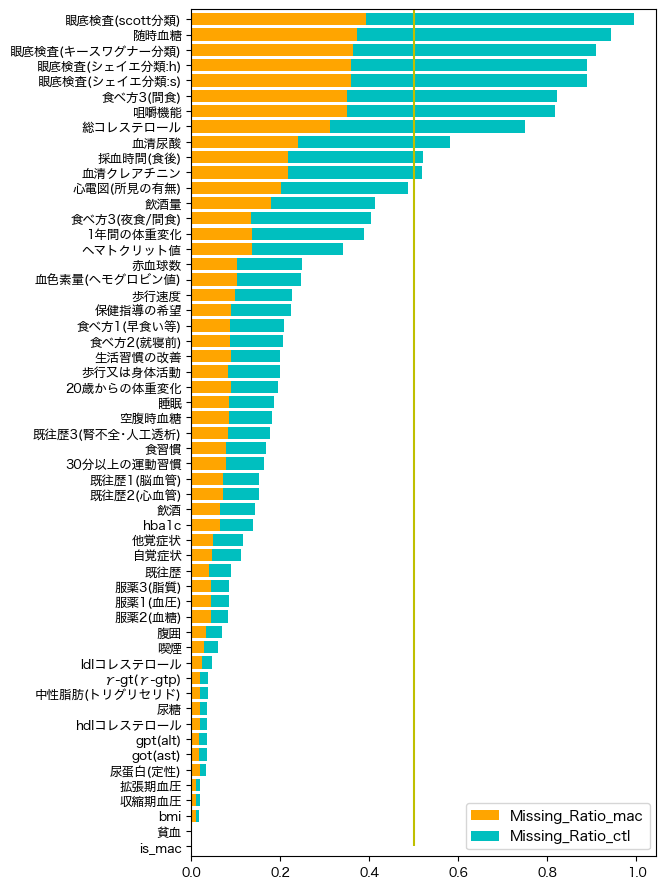

In [41]:
import pandas as pd
import numpy as np

data = pd.read_csv('./data/Kenshin_Syobyo_merged.csv',parse_dates=['健診実施年月日'])

# Calculate the number of months from the health check-up to the onset of the disease.
# maculopathy:DME onset date, control: the end of observation date
kanja_summary = pd.read_csv('./data/kanja_summary.csv',parse_dates=['発症年月日'])
kanja_summary['観察終了年月'] = pd.to_datetime(kanja_summary['観察終了年月'], format='%Y%m')
kanja_summary['加入者生年月'] = pd.to_datetime(kanja_summary['加入者生年月'], format='%Y%m')
kanja_summary['糖尿病発症年月日'] = pd.to_datetime(kanja_summary['糖尿病発症年月日'])
data = pd.merge(data,kanja_summary[['加入者id','発症年月日','観察終了年月','加入者生年月','加入者性別','糖尿病発症年月日']],on='加入者id',how='left')
data.loc[data.is_mac == 0,'発症年月日']=data['観察終了年月']

data['month_maculopathy'] = (
           data['発症年月日'].dt.to_period('M').astype('int')
         - data['健診実施年月日'].dt.to_period('M').astype('int')
)
data['age'] = ((
           data['健診実施年月日'].dt.to_period('M').astype('int')
         - data['加入者生年月'].dt.to_period('M').astype('int')
) //12 )

# duration_DM
data['duration_DM'] = (
           data['健診実施年月日'].dt.to_period('M').astype('int')
         - data['糖尿病発症年月日'].dt.to_period('M').astype('int')
)
data.loc[data['duration_DM'] < 0,'duration_DM'] = 0

data['gender'] = [1 if i == "男性" else 0 for i in data["加入者性別"]]

# Restrict to pre-onset only
data = data.loc[data['month_maculopathy']>=0,:]

data.drop(columns=['健診id','yearmonth','健診実施年月日','発症年月日','糖尿病発症年月日','観察終了年月','加入者生年月','加入者性別'],inplace=True)
cols = data.columns.tolist() 
new_cols = cols[:1] + cols[-5:] + cols[1:-5] 
data = data[new_cols]

# Check missing values
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rc('font', family='Hiragino Sans')

kenshin = pd.concat([data.loc[:,'bmi':'総コレステロール'],data[['is_mac']]],axis=1)

null_count = kenshin.isnull().sum()
null_rate = null_count / len(kenshin)
null_count_mac = kenshin[kenshin.is_mac==1].isnull().sum()
null_rate_mac = null_count_mac / len(kenshin)
null_count_ctl = kenshin[kenshin.is_mac==0].isnull().sum()
null_rate_ctl = null_count_ctl / len(kenshin)

df_missing = pd.DataFrame({
    'Missing_Ratio': null_rate,
    'Missing_Ratio_mac': null_rate_mac,
    'Missing_Ratio_ctl': null_rate_ctl
    }, index=kenshin.columns)

df_missing.sort_values(by='Missing_Ratio', ascending=True, inplace=True)
df_missing.plot.barh(y=['Missing_Ratio_mac','Missing_Ratio_ctl'],figsize=(6,11), 
                     width=0.8,fontsize=9,stacked=True,color={"Missing_Ratio_mac": "orange", "Missing_Ratio_ctl": "c"})
plt.vlines(x=0.5, ymin=0, ymax=len(df_missing.index),label=False,color='y')

# Drop variables with missing values of 50% or more
missing_vars = df_missing.loc[df_missing["Missing_Ratio"] > 0.5,:].index
print(missing_vars)
data.drop(missing_vars, axis=1,inplace=True)

data.to_csv('./data/before_interpolate.csv',index=False)

In [39]:
# 欠損がある健診データはないのを確認
shobyo = pd.concat([data.loc[:,'高血圧症':'頻脈性不整脈'],data[['is_mac']]],axis=1)
# syobyoで欠損のあるデータ
null_count = shobyo.isnull().sum()
print(sum(null_count))


0
